# EV presence and consumption

Authors: Alessio Carnevale, Manuel Cattoni

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller, kpss
import pandas as pd
import warnings

In [4]:
df = pd.read_csv('data/ev_dataset.csv', delimiter=';')

This [dataset](https://data.4tu.nl/datasets/80ef3824-3f5d-4e45-8794-3b8791efbd13/1) collects 55,000 unique charging sessions from a large public parking lot in Utrecht.

In [5]:
print("Length of Dataset:", len(df))
df.info()

Length of Dataset: 55379
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55379 entries, 0 to 55378
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   EV_id_x                    55379 non-null  object 
 1   start_datetime             55379 non-null  object 
 2   end_datetime               55379 non-null  object 
 3   total_energy               55379 non-null  float64
 4   rail                       55379 non-null  object 
 5   evse_uid                   55379 non-null  int64  
 6   channel                    55379 non-null  int64  
 7   capacity_kwh               3829 non-null   float64
 8   commute_km_range_min       4053 non-null   float64
 9   commute_km_range_max       4053 non-null   float64
 10  EV_brand_selfreported      4053 non-null   object 
 11  EV_model_selfreported      4053 non-null   object 
 12  capacity_kwh_selfreported  4053 non-null   object 
 13  ownership            

In [6]:
df.head()

,EV_id_x,start_datetime,end_datetime,total_energy,rail,evse_uid,channel,capacity_kwh,commute_km_range_min,commute_km_range_max,EV_brand_selfreported,EV_model_selfreported,capacity_kwh_selfreported,ownership
0,EV0,2020-08-25 11:56:02,2020-08-25 12:08:15,1.477,mennekes,600001,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,EV0,2020-08-25 12:20:30,2020-08-25 12:32:16,1.333,mennekes,600002,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,EV0,2020-08-25 12:40:47,2020-08-25 13:01:23,2.330,mennekes,600003,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,EV0,2020-08-25 13:05:31,2020-08-25 13:37:29,3.764,mennekes,600005,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,EV0,2020-08-25 14:03:28,2020-08-25 14:23:03,2.297,mennekes,600000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Convert start and end columns to datetime if not already
df['start_datetime'] = pd.to_datetime(df['start_datetime'])
df['end_datetime'] = pd.to_datetime(df['end_datetime'])

# Calculate duration in hours
df['duration'] = (df['end_datetime'] - df['start_datetime']).dt.total_seconds() / 3600

# Calculate average duration
avg_duration = df['duration'].mean()
print(f"Average charging duration: {avg_duration:.2f} hours")

Average charging duration: 6.55 hours


## Visualizations on Dataset

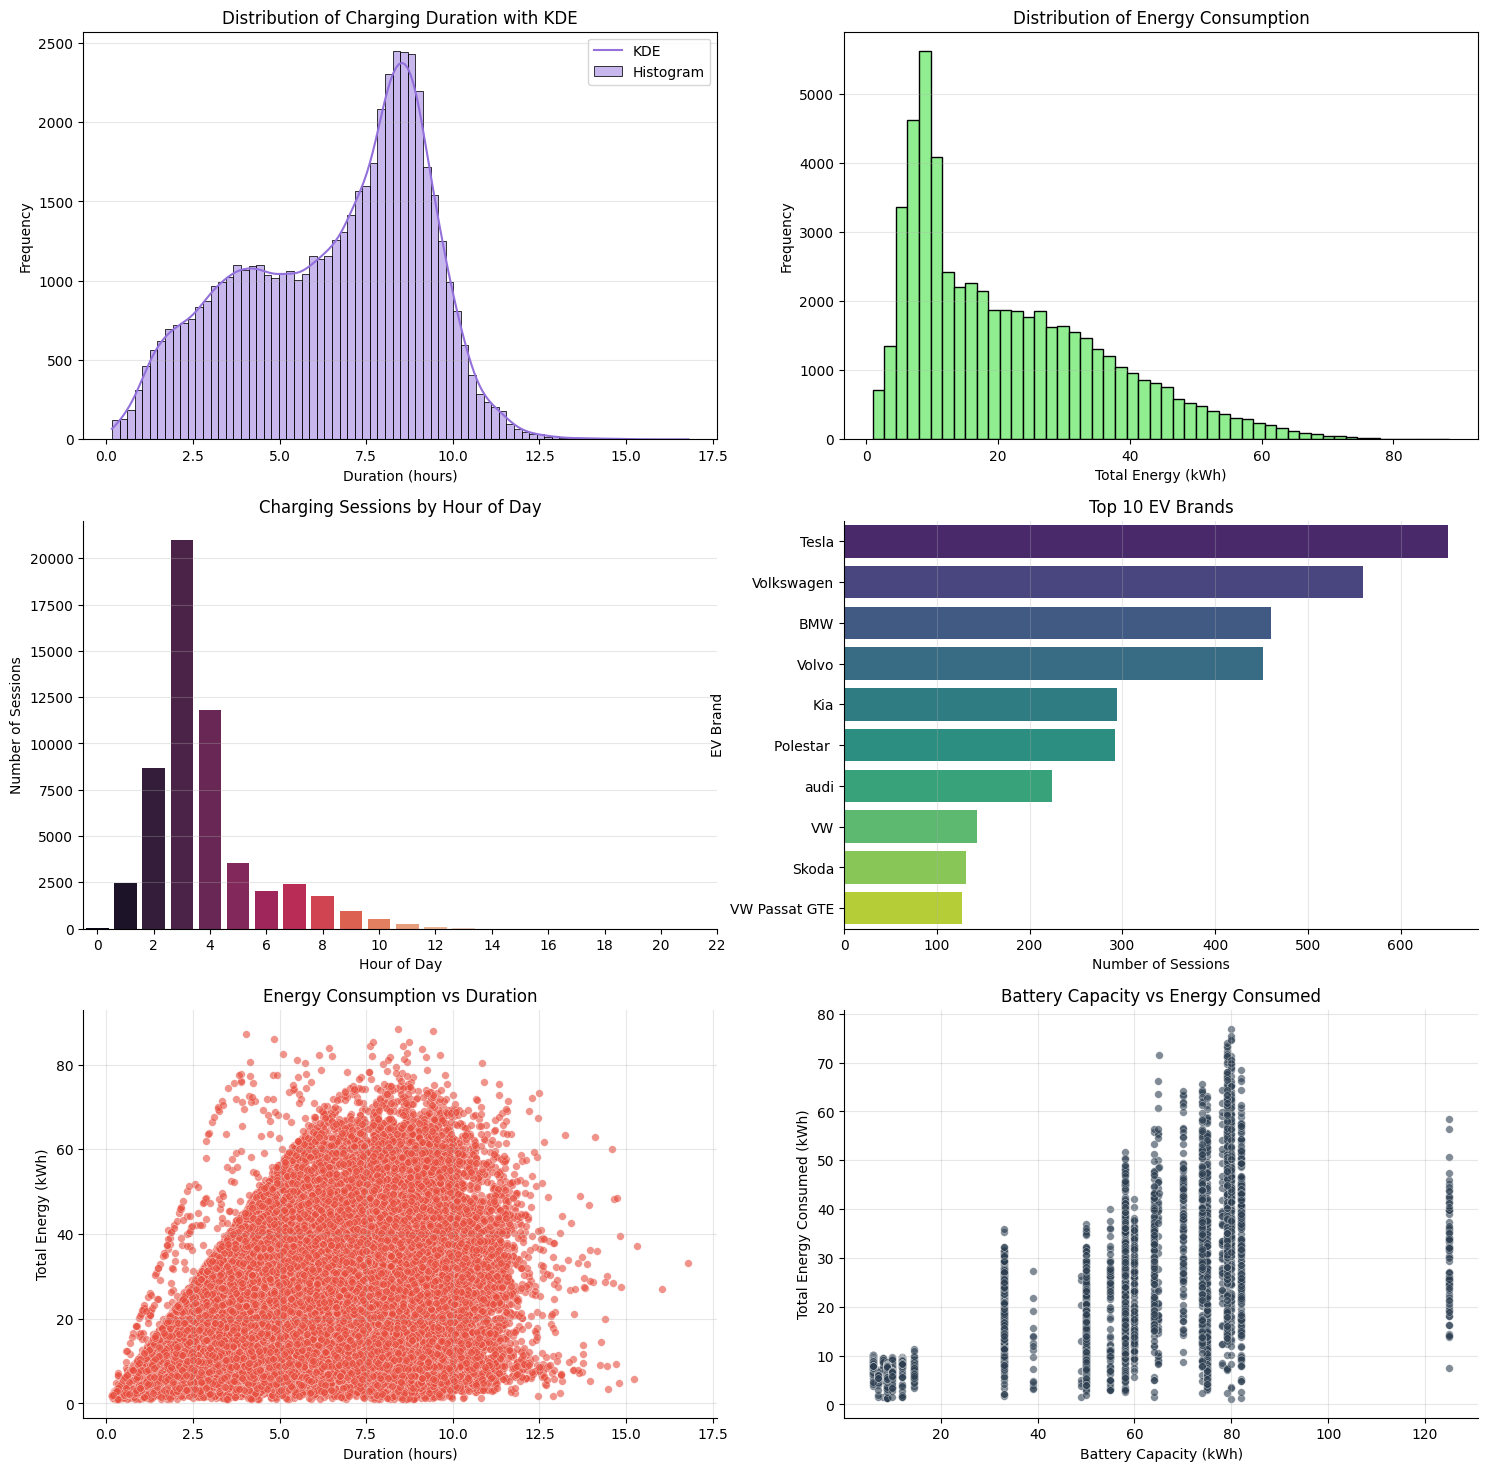

In [8]:
# Create a figure with multiple subplots
fig, axes = plt.subplots(3, 2, figsize=(18, 18))

# 1. Distribution plot of duration
sns.histplot(data=df, x='duration', kde=True, ax=axes[0, 0], color='mediumpurple', edgecolor='black')
axes[0, 0].set_title('Distribution of Charging Duration with KDE')
axes[0, 0].set_xlabel('Duration (hours)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(axis='y', alpha=0.3)
axes[0, 0].legend(['KDE', 'Histogram'])

# 2. Distribution of total energy consumed
axes[0, 1].hist(df['total_energy'], bins=50, edgecolor='black', color='lightgreen')
axes[0, 1].set_xlabel('Total Energy (kWh)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Energy Consumption')
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Charging sessions by hour of day
df['start_hour'] = df['start_datetime'].dt.hour
hourly_sessions = df['start_hour'].value_counts().sort_index()

sns.barplot(data=pd.DataFrame({'hour': hourly_sessions.index, 'sessions': hourly_sessions.values}),
            x='hour', y='sessions', hue='hour', 
            palette='rocket', ax=axes[1, 0], saturation=0.8, legend=False)

axes[1, 0].set_xlabel('Hour of Day')
axes[1, 0].set_ylabel('Number of Sessions')
axes[1, 0].set_title('Charging Sessions by Hour of Day')
axes[1, 0].set_xticks(range(0, 24, 2))
axes[1, 0].set_xticklabels(range(0, 24, 2))
axes[1, 0].grid(axis='y', alpha=0.3)
axes[1, 0].spines['top'].set_visible(False)
axes[1, 0].spines['right'].set_visible(False)

# 4. Top EV brands
top_brands = df['EV_brand_selfreported'].value_counts().head(10)

sns.barplot(data=pd.DataFrame({'brand': top_brands.index, 'count': top_brands.values}),
            y='brand', x='count', hue='brand',
            palette='viridis', ax=axes[1, 1], saturation=0.8, legend=False)

axes[1, 1].set_xlabel('Number of Sessions')
axes[1, 1].set_ylabel('EV Brand')
axes[1, 1].set_title('Top 10 EV Brands')
axes[1, 1].grid(axis='x', alpha=0.3)
axes[1, 1].spines['top'].set_visible(False)
axes[1, 1].spines['right'].set_visible(False)

# 5. Energy vs Duration scatter plot
sns.scatterplot(x='duration', y='total_energy', data=df, 
                alpha=0.6, s=30, color='#e74c3c', 
                edgecolor='white', linewidth=0.3, ax=axes[2, 0])

# Styling
axes[2, 0].set_xlabel('Duration (hours)')
axes[2, 0].set_ylabel('Total Energy (kWh)')
axes[2, 0].set_title('Energy Consumption vs Duration')
axes[2, 0].grid(alpha=0.3)
axes[2, 0].spines['top'].set_visible(False)
axes[2, 0].spines['right'].set_visible(False)

# 6. Capacity vs Total Energy scatter
sns.scatterplot(x='capacity_kwh', y='total_energy', data=df, 
                alpha=0.6, s=30, color='#2c3e50', 
                edgecolor='white', linewidth=0.3, ax=axes[2, 1])

# Styling
axes[2, 1].set_xlabel('Battery Capacity (kWh)')
axes[2, 1].set_ylabel('Total Energy Consumed (kWh)')
axes[2, 1].set_title('Battery Capacity vs Energy Consumed')
axes[2, 1].grid(alpha=0.3)
axes[2, 1].spines['top'].set_visible(False)
axes[2, 1].spines['right'].set_visible(False)

## Correlation Matrix

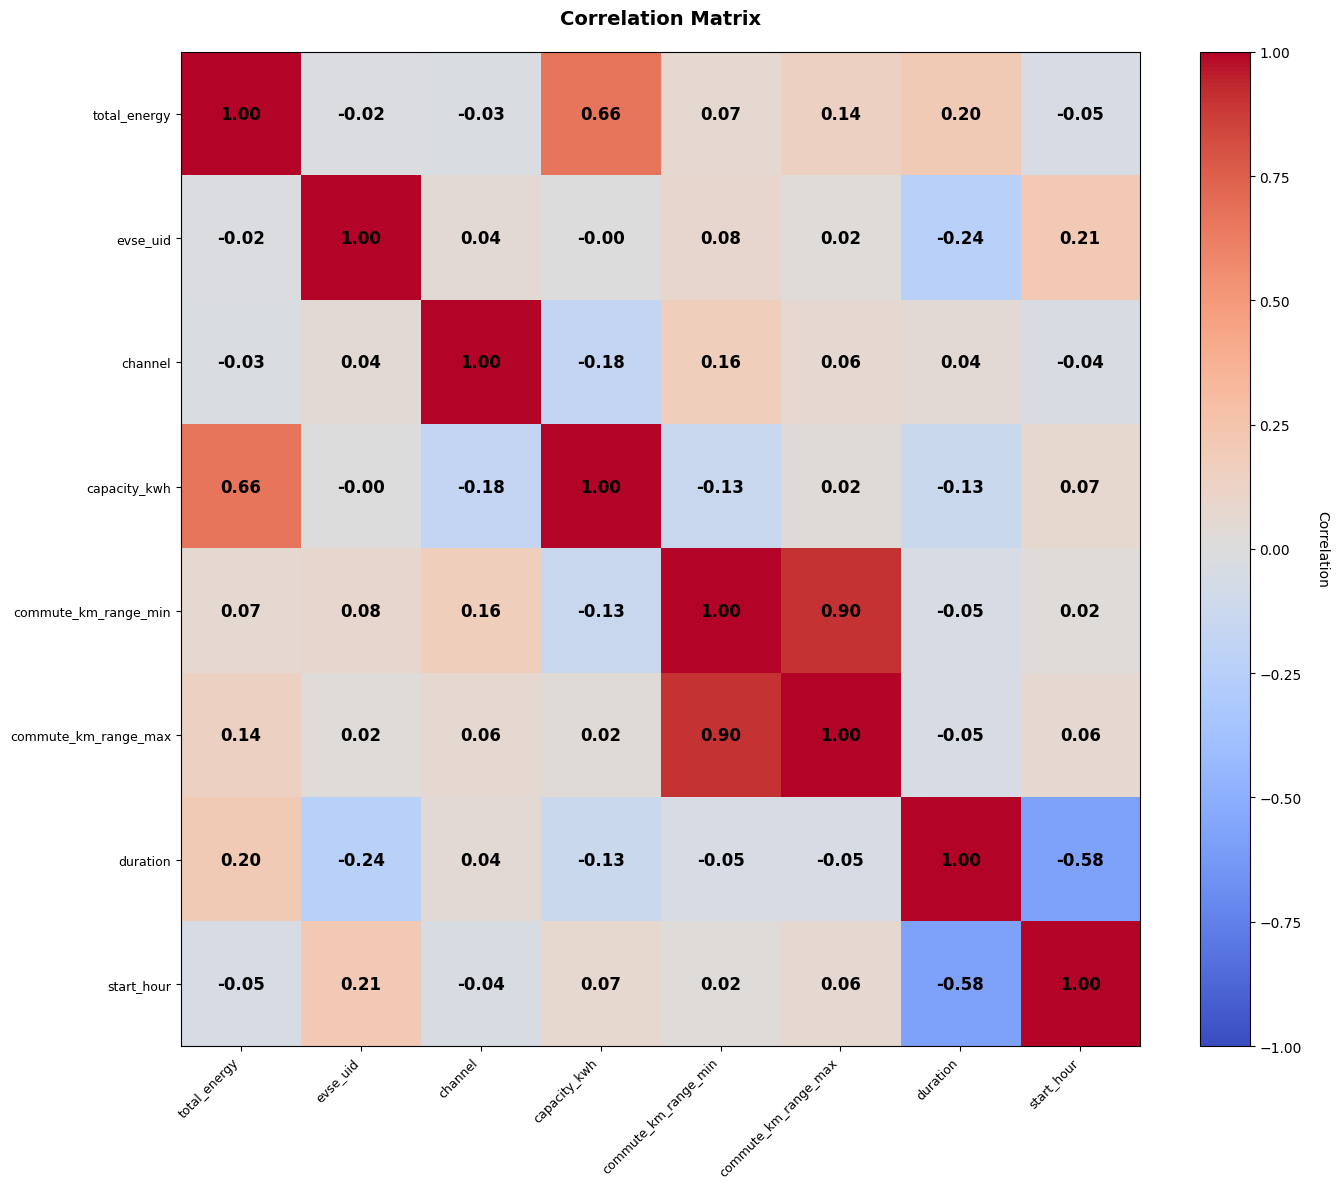

In [9]:

# Calculate correlation matrix for numeric columns
correlation_matrix = df.select_dtypes(include=['number']).corr()

# Create heatmap
fig, ax = plt.subplots(figsize=(14, 12))

# Create the heatmap using imshow
im = ax.imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')

# Set ticks and labels
ax.set_xticks(range(len(correlation_matrix.columns)))
ax.set_yticks(range(len(correlation_matrix.columns)))
ax.set_xticklabels(correlation_matrix.columns, rotation=45, ha='right', fontsize=9)
ax.set_yticklabels(correlation_matrix.columns, fontsize=9)

# Add text annotations for all values
for i in range(len(correlation_matrix)):
    for j in range(len(correlation_matrix)):
        text = ax.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}',
                      ha="center", va="center", color="black", fontsize=12, weight='bold')

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Correlation', rotation=270, labelpad=20)

ax.set_title('Correlation Matrix', fontsize=14, pad=20, weight='bold')
plt.tight_layout()
plt.show()

## ACF Plot

<Figure size 1000x400 with 0 Axes>

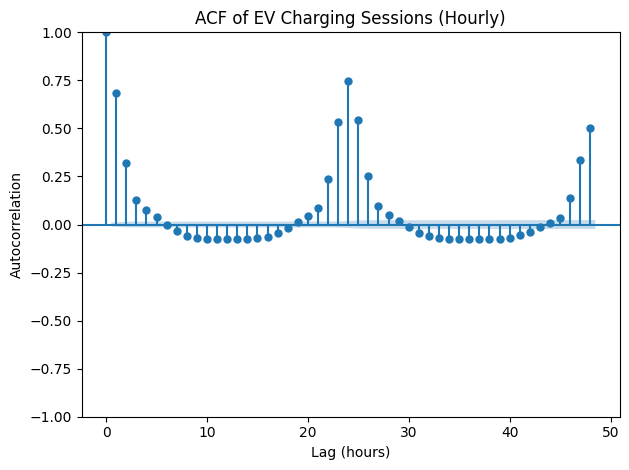

In [10]:
ts = (
    df
    .set_index('start_datetime')
    .resample('h')
    .size()
)

plt.figure(figsize=(10, 4))
plot_acf(ts, lags=48)
plt.title("ACF of EV Charging Sessions (Hourly)")
plt.xlabel("Lag (hours)")
plt.ylabel("Autocorrelation")
plt.tight_layout()
plt.show()


# Dataset transformation

The code assumes that the charging power is constant throughout the session.$$\text{Average Power (kW)} = \frac{\text{Total Energy (kWh)}}{\text{Session Duration (h)}}$$

In [11]:
def create_time_series_optimized(df, group_col=None):
    """
    Converts charging session data into an hourly time series.
    Logic: Distributes energy proportionally based on the exact overlap 
    between the session duration and the specific hour.
    """    
    # 1. Calculate average power (kW) for each session
    df = df.copy()
    duration_h = (df['end_datetime'] - df['start_datetime']).dt.total_seconds() / 3600
    
    # Division by zero or extremely short durations
    df['avg_power_kw'] = np.where(duration_h > 0.001, df['total_energy'] / duration_h, 0)
    
    records = []
    
    # 2. iterate
    for row in df.itertuples():
        t_start = row.start_datetime
        t_end = row.end_datetime
        
        # Define the start and end hour buckets
        start_bucket = t_start.floor('h')
        end_bucket = t_end.ceil('h')
        
        # Generate all hourly timestamps involved in this session
        buckets = pd.date_range(start_bucket, end_bucket, freq='h', inclusive='left')
        
        for bucket in buckets:
            # Define the end of the current hour bucket
            bucket_end = bucket + pd.Timedelta(hours=1)
            
            # Calculate the exact time overlap in this specific hour
            # Overlap is the intersection: [max(start), min(end)]
            overlap_start = max(bucket, t_start)
            overlap_end = min(bucket_end, t_end)
            
            seconds_active = (overlap_end - overlap_start).total_seconds()
            
            if seconds_active > 0:
                hours_active = seconds_active / 3600
                
                # Energy = Time Active (h) * Power (kW)
                consumption = hours_active * row.avg_power_kw
                
                record = {
                    'timestamp': bucket,
                    'consumption': consumption,
                    'presence': 1  # flag (active during this hour ?)
                }
                
                # column (e.g., 'rail') if requested
                if group_col:
                    record[group_col] = getattr(row, group_col)
                    
                records.append(record)

    return pd.DataFrame(records)

In [12]:
# Generate the new staset
df_expanded = create_time_series_optimized(df, group_col='rail')

# 1. Fleet TS (aggregation)
fleet_ts = df_expanded.groupby('timestamp').agg({
    'presence': 'sum',
    'consumption': 'sum'
}).resample('h').asfreq().fillna(0)

# 2. Rail TS (Unstacking)
rail_ts = df_expanded.groupby(['timestamp', 'rail']).agg({
    'presence': 'sum',
    'consumption': 'sum'
}).unstack(fill_value=0)

print("-" * 40)
print("Transformation Complete.")
print(f"Fleet TS Shape: {fleet_ts.shape}")
print("Fleet TS Head:")
print(fleet_ts.head())

print("--- Energy Conservation Check ---")

# Calculate totas
total_energy_raw = df['total_energy'].sum()
total_energy_ts = fleet_ts['consumption'].sum()
diff = total_energy_ts - total_energy_raw

print(f"Total Energy in Raw Dataset: {total_energy_raw:,.2f} kWh")
print(f"Total Energy in Time Series: {total_energy_ts:,.2f} kWh")
print(f"Difference: {diff:,.2f} kWh")

# Validation logic
if abs(diff) < 1.0:
    print("Result: Energy is conserved perfectly.")
else:
    print("Result: WARNING. Significant energy discrepancy found.")

----------------------------------------
Transformation Complete.
Fleet TS Shape: (35982, 2)
Fleet TS Head:
                     presence  consumption
timestamp                                 
2020-08-25 11:00:00       1.0     0.479572
2020-08-25 12:00:00       3.0     4.503964
2020-08-25 13:00:00       2.0     3.920464
2020-08-25 14:00:00       2.0     7.184000
2020-08-25 15:00:00       0.0     0.000000
--- Energy Conservation Check ---
Total Energy in Raw Dataset: 1,193,202.00 kWh
Total Energy in Time Series: 1,193,202.00 kWh
Difference: 0.00 kWh
Result: Energy is conserved perfectly.


In [13]:
def prepare_features(df_ts):
    df = df_ts.copy()
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    
    # Lag features: the value from the previous hour or the previous day
    df['consumption_lag_24'] = df['consumption'].shift(24) # Consumo stessa ora ieri
    df['presence_lag_24'] = df['presence'].shift(24)
    
    return df.dropna()

fleet_features = prepare_features(fleet_ts)

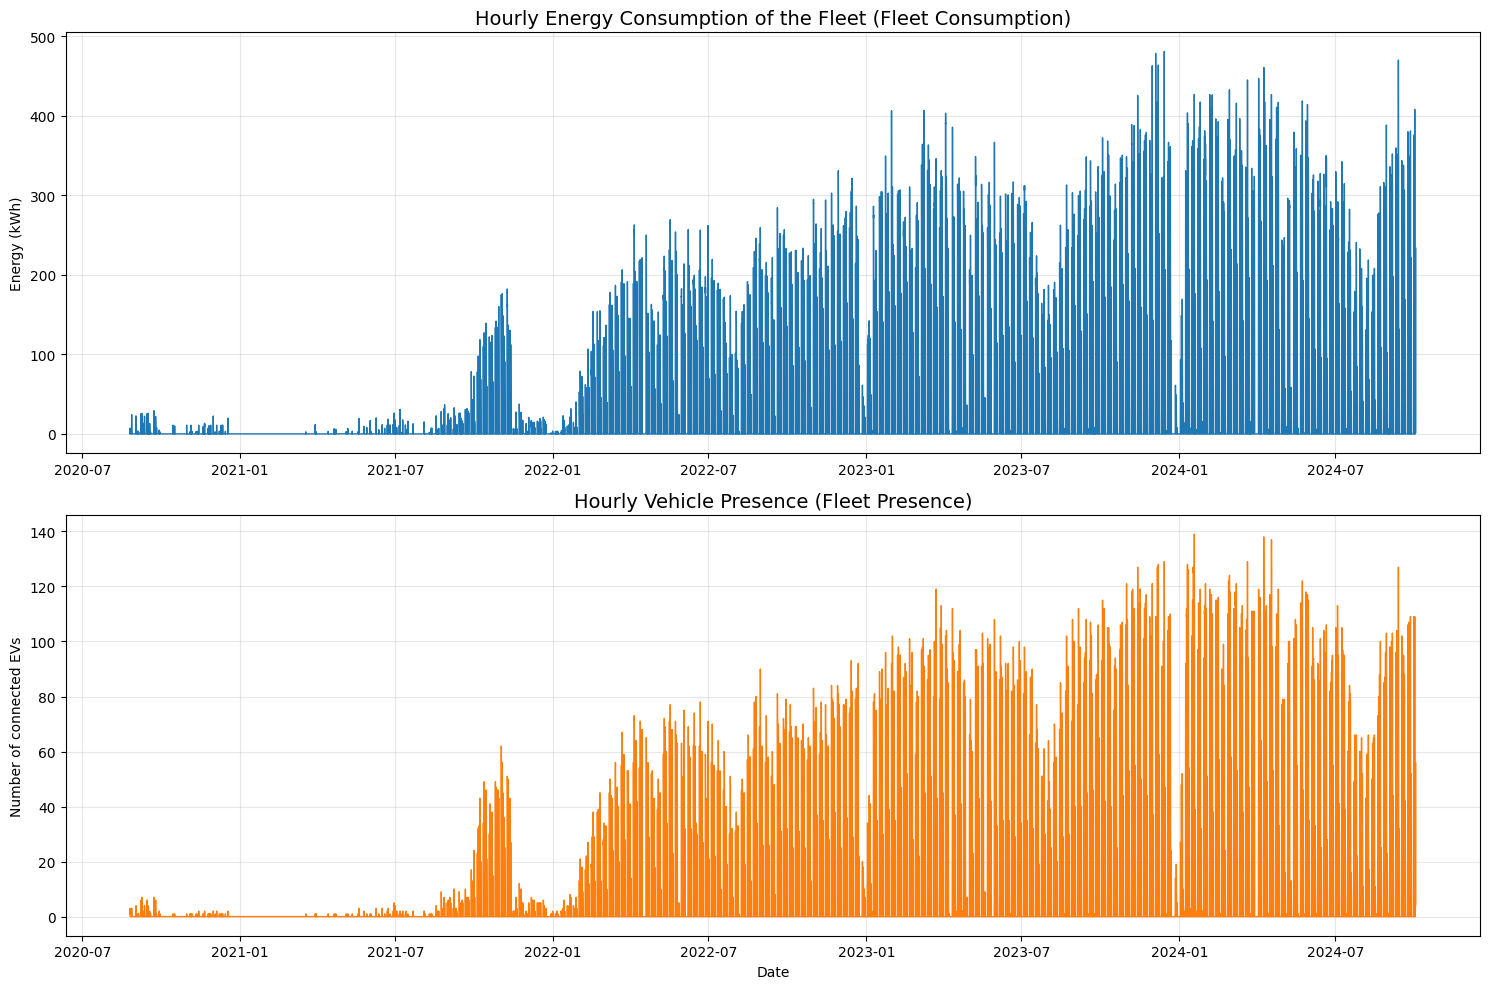

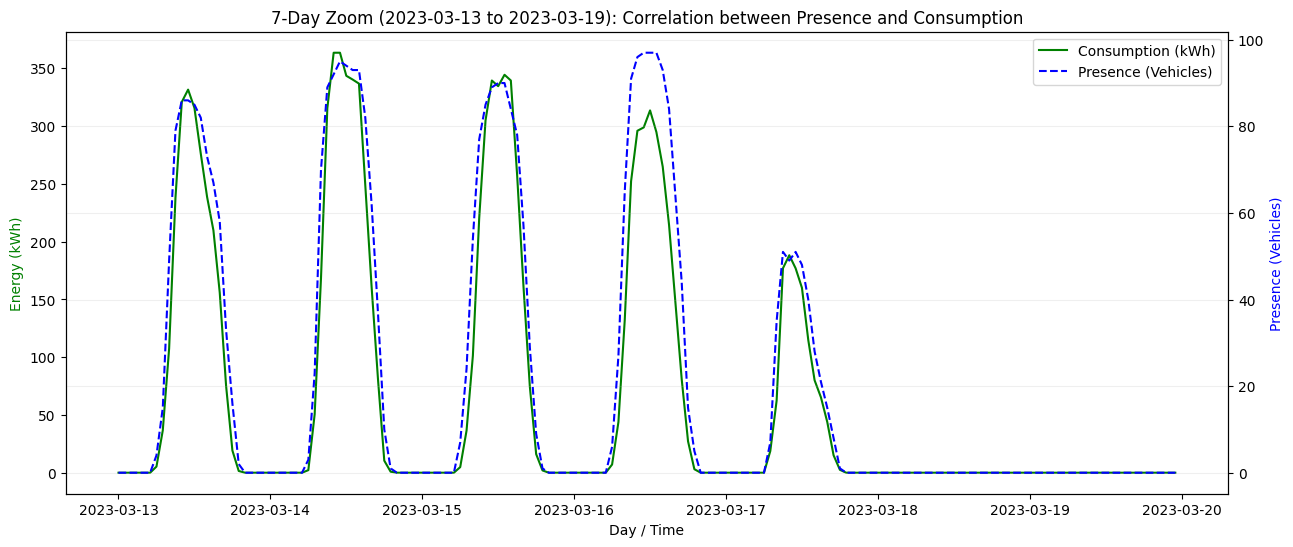

In [14]:
plt.figure(figsize=(15, 10))

# plot 1: total eergy consumption 
plt.subplot(2, 1, 1)
plt.plot(fleet_ts.index, fleet_ts['consumption'], color='tab:blue', linewidth=1)
plt.title('Hourly Energy Consumption of the Fleet (Fleet Consumption)', fontsize=14)
plt.ylabel('Energy (kWh)')
plt.grid(True, alpha=0.3)

# Plot 2: veichle presence
plt.subplot(2, 1, 2)
plt.plot(fleet_ts.index, fleet_ts['presence'], color='tab:orange', linewidth=1)
plt.title('Hourly Vehicle Presence (Fleet Presence)', fontsize=14)
plt.ylabel('Number of connected EVs')
plt.xlabel('Date')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# zoom to a  week in March 2023 
# from Mon 13 March to Sunday, 19th
start_date = '2023-03-13'
end_date = '2023-03-19'
sample_week = fleet_ts.loc[start_date:end_date]

fig, ax1 = plt.subplots(figsize=(15, 6))

ax2 = ax1.twinx()
# Consumption on the primary Y (left)
ax1.plot(sample_week.index, sample_week['consumption'], 'g-', label='Consumption (kWh)')
# Presence on the secondary Y (right)
ax2.plot(sample_week.index, sample_week['presence'], 'b--', label='Presence (Vehicles)')

ax1.set_xlabel('Day / Time')
ax1.set_ylabel('Energy (kWh)', color='g')
ax2.set_ylabel('Presence (Vehicles)', color='b')
plt.title(f'7-Day Zoom ({start_date} to {end_date}): Correlation between Presence and Consumption')
plt.grid(True, alpha=0.2)

# Combining legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

plt.show()

In [15]:
for rail in ['B', 'C', 'E', 'H', 'J']:
    ts = rail_ts['consumption'][rail]
    train = ts.loc[:'2023-03-15 23:00:00']
    
    print(f"\nRail {rail}:")
    print(f"  Mean: {train.mean():.2f}")
    print(f"  Std: {train.std():.2f}")
    print(f"  Min: {train.min():.2f}")
    print(f"  Max: {train.max():.2f}")
    print(f"  CV (Std/Mean): {train.std()/train.mean():.4f}")
    print(f"  % zeros: {(train == 0).sum() / len(train) * 100:.1f}%")



Rail B:
  Mean: 14.47
  Std: 16.02
  Min: 0.00
  Max: 98.39
  CV (Std/Mean): 1.1068
  % zeros: 26.6%

Rail C:
  Mean: 4.47
  Std: 8.06
  Min: 0.00
  Max: 66.49
  CV (Std/Mean): 1.8038
  % zeros: 54.8%

Rail E:
  Mean: 20.68
  Std: 23.18
  Min: 0.00
  Max: 107.49
  CV (Std/Mean): 1.1206
  % zeros: 19.5%

Rail H:
  Mean: 18.50
  Std: 21.61
  Min: 0.00
  Max: 115.64
  CV (Std/Mean): 1.1682
  % zeros: 28.1%

Rail J:
  Mean: 4.16
  Std: 7.82
  Min: 0.00
  Max: 45.14
  CV (Std/Mean): 1.8771
  % zeros: 61.7%


## Stationary test

In [16]:
def check_stationarity_flexible(series, name, lags_to_test=[24, 168]):
    """
    Checks stationarity for Raw data, and then for specific Seasonal Lags.
    """
    print(f"======= Stationarity Analysis: {name} =======")
    
    # Helper function
    def run_tests(data, desc):
        # ADF Test 
        adf = adfuller(data.dropna(), autolag='AIC')
        
        # KPSS Test
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            kpss_res = kpss(data.dropna(), regression='c', nlags="auto")
            
        print(f'   ADF p-value:  {adf[1]:.4f}')
        print(f'   KPSS p-value: {kpss_res[1]:.4f}')
        
        is_stat = (adf[1] < 0.05) and (kpss_res[1] > 0.05)
        print(f"   Result: {'STATIONARY' if is_stat else 'NON-STATIONARY'}")
        return is_stat

    # 1. Test raw data
    if run_tests(series, "Raw Data"):
        print("Conclusion: Raw data is stationary.")
        print("=" * 60)
        return

    # 2. Test seasonal differences (24 and 168)
    for lag in lags_to_test:
        diff_series = series.diff(lag).dropna()
        if run_tests(diff_series, f"Seasonally Differenced (Lag {lag})"):
            print(f"\nConclusion: Series becomes stationary with Lag {lag} differencing.")
            print(f"Insight: The main cycle is {lag} hours.")
            print("=" * 60)
            return

    print("\nConclusion: Series is still non-stationary or complex.")
    print("=" * 60)

# test with boyh 1day (24h) and 1 week (168h)
check_stationarity_flexible(fleet_ts['consumption'], "Fleet Consumption", lags_to_test=[24, 168])

======= Stationarity Analysis: Fleet Consumption =======
   ADF p-value:  0.0000
   KPSS p-value: 0.0100
   Result: NON-STATIONARY
   ADF p-value:  0.0000
   KPSS p-value: 0.1000
   Result: STATIONARY

Conclusion: Series becomes stationary with Lag 24 differencing.
Insight: The main cycle is 24 hours.


Interpretation of Stationarity Tests
The stationarity analysis reveals a critical insight into the data structure:

Raw Data Conflict: The raw series shows conflicting results (ADF rejects unit root, but KPSS rejects stationarity). This is a classic signature of Seasonal Non-Stationarity. The mean is not constant because it follows a strong daily pattern (0 kWh at night, peak during the day).

Effect of Differencing: Applying a 24-hour seasonal difference (Lag 24) makes the series strictly stationary (KPSS p-value > 0.05). This confirms that the primary driver of the series is the daily cycle.

Modeling Strategy
Since the non-stationarity is driven by seasonality, we do not need to difference the target variable for the Machine Learning model (which would require complex inversion steps).

Instead, we will capture this structure by Feature Engineering:

We will introduce Lag Features (specifically Lag_24 and Lag_168) as input variables.

This allows the XGBoost model to learn the daily and weekly seasonality directly from the raw data, effectively "stationarizing" the problem internally without altering the target consumption values.

## Simple models

Functions

In [32]:
def cast_df(y, df):
    h = len(y)
    return pd.DataFrame(y, index=pd.date_range(
        start=df.index[-1] + pd.Timedelta(hours=1), periods=h, freq='h'))

def naive(x, h): 
    return cast_df(np.repeat(x.iloc[-1], h), x)

def mean_fc(x, h): 
    return cast_df(np.repeat(x.mean(), h), x)

def seasonal_naive(x, h, m=24):
    values = x.iloc[-m:].values
    y_hat = np.tile(values, int(np.ceil(h/m)))[:h]
    return cast_df(y_hat, x)

def calculate_nmae(y_true, y_pred, y_train_mean):
    # mae = np.mean(np.abs(y_true - y_pred))
    # mae_baseline = np.mean(np.abs(y_true - y_train_mean))
    # return mae / mae_baseline if mae_baseline != 0 else np.nan
    mae = np.mean(np.abs(y_true - y_pred))
    mae_baseline = np.mean(np.abs(y_true - np.mean(y_true)))  
    return mae / mae_baseline if mae_baseline != 0 else np.nan

In [ ]:
def rolling_window_cv(ts_series, model_func, h_ahead=24, n_splits=10):
    """ time series CV w expanding window"""
    
    results = {'mae': [], 'nmae': [], 'actuals': [], 'forecasts': []}
    
    step = (len(ts_series) - h_ahead) // (n_splits + 1)
    
    for i in range(n_splits):
        train_end_idx = len(ts_series) - h_ahead - (n_splits - i) * step
        train = ts_series.iloc[:train_end_idx]
        test = ts_series.iloc[train_end_idx:train_end_idx + h_ahead]
        
        if len(test) < h_ahead:
            continue
        
        y_pred = model_func(train, h_ahead).values.ravel()
        y_true = test.values
        
        mae = np.mean(np.abs(y_true - y_pred))
        nmae = calculate_nmae(y_true, y_pred, train.mean())
        
        results['mae'].append(mae)
        results['nmae'].append(nmae)
        results['actuals'].append(y_true)
        results['forecasts'].append(y_pred)
    
    return results

# Benchmark for rails
def benchmark_per_rail(ts_data, target_name, split_date='2023-03-15 23:00:00', h_ahead=24):
    """Naive results for each rail"""
    
    print(f"\n{'='*55}")
    print(f"BENCHMARK NAIVE - {target_name.upper()}")
    print(f"{'='*55}")
    
    bench_results = {}
    split_datetime = pd.to_datetime(split_date)
    
    for rail in ts_data.columns:
        ts = ts_data[rail]
        train = ts.loc[:split_date]
        test = ts.loc[split_datetime + pd.Timedelta(hours=1):].iloc[:h_ahead]
        
        if len(test) < h_ahead:
            continue
        
        y_true = test.values
        
        # Forecasts
        y_naive = naive(train, h_ahead).values.ravel()
        y_mean = mean_fc(train, h_ahead).values.ravel()
        y_snai = seasonal_naive(train, h_ahead).values.ravel()
        
        # Metrics
        bench_results[rail] = {
            'Naive': calculate_nmae(y_true, y_naive, train.mean()),
            'Mean': calculate_nmae(y_true, y_mean, train.mean()),
            'S_Naive': calculate_nmae(y_true, y_snai, train.mean())
        }
    
    df_bench = pd.DataFrame(bench_results).T
    
    print(f"\nProcessed {len(bench_results)} rails\n")
    print(df_bench.round(4))
    print(f"\n{'-'*55}")
    print("Summary Statistics:")
    print(df_bench.describe().round(4))
    print(f"{'-'*55}\n")
    
    return df_bench


# Benchmark fleet
def benchmark_fleet(ts_series, target_name, split_date='2023-03-15 23:00:00', h_ahead=24):
    """Benchmark fleet level con rolling window CV + test set."""
    
    print(f"\n{'='*55}")
    print(f"BENCHMARK FLEET - {target_name.upper()}")
    print(f"{'='*55}\n")
    
    split_datetime = pd.to_datetime(split_date)
    
    # Cross-validation
    print("📊 ROLLING WINDOW CV (10 folds):")
    print(f"{'-'*55}")
    
    cv_naive = rolling_window_cv(ts_series, naive, h_ahead=h_ahead, n_splits=10)
    cv_mean = rolling_window_cv(ts_series, mean_fc, h_ahead=h_ahead, n_splits=10)
    cv_snai = rolling_window_cv(ts_series, seasonal_naive, h_ahead=h_ahead, n_splits=10)
    
    print(f"\nNaive   | MAE: {np.mean(cv_naive['mae']):.4f} ± {np.std(cv_naive['mae']):.4f} | "
          f"nMAE: {np.nanmean(cv_naive['nmae']):.4f} ± {np.nanstd(cv_naive['nmae']):.4f}")
    print(f"Mean    | MAE: {np.mean(cv_mean['mae']):.4f} ± {np.std(cv_mean['mae']):.4f} | "
          f"nMAE: {np.nanmean(cv_mean['nmae']):.4f} ± {np.nanstd(cv_mean['nmae']):.4f}")
    print(f"S_Naive | MAE: {np.mean(cv_snai['mae']):.4f} ± {np.std(cv_snai['mae']):.4f} | "
          f"nMAE: {np.nanmean(cv_snai['nmae']):.4f} ± {np.nanstd(cv_snai['nmae']):.4f}")
    
    # Test set
    print(f"\n{'-'*55}")
    print(f"📋 TEST SET ({split_date}):")
    print(f"{'-'*55}\n")
    
    train = ts_series.loc[:split_date]
    test = ts_series.loc[split_datetime + pd.Timedelta(hours=1):].iloc[:h_ahead]
    
    if len(test) >= h_ahead:
        y_true = test.values
        
        y_naive = naive(train, h_ahead).values.ravel()
        y_mean = mean_fc(train, h_ahead).values.ravel()
        y_snai = seasonal_naive(train, h_ahead).values.ravel()
        
        nmae_naive = calculate_nmae(y_true, y_naive, train.mean())
        nmae_mean = calculate_nmae(y_true, y_mean, train.mean())
        nmae_snai = calculate_nmae(y_true, y_snai, train.mean())
        
        print(f"Naive   nMAE: {nmae_naive:.4f}")
        print(f"Mean    nMAE: {nmae_mean:.4f}")
        print(f"S_Naive nMAE: {nmae_snai:.4f} ← BASELINE\n")


def plot_fleet_forecast(ts_series, split_date='2023-03-15 23:00:00', h_ahead=24, target_name='Consumption'):
    """Plot fleet forecast vs actual."""
    
    split_datetime = pd.to_datetime(split_date)
    train = ts_series.loc[:split_date]
    test = ts_series.loc[split_datetime + pd.Timedelta(hours=1):].iloc[:h_ahead]
    
    y_naive = naive(train, h_ahead).values.ravel()
    y_mean = mean_fc(train, h_ahead).values.ravel()
    y_snai = seasonal_naive(train, h_ahead).values.ravel()
    
    fig, ax = plt.subplots(figsize=(14, 6))
    hours = np.arange(h_ahead)
    
    ax.plot(hours, test.values, marker='o', label='Actual', linewidth=2.5, 
            color='black', markersize=6, zorder=5)
    ax.plot(hours, y_naive, linestyle='--', label='Naive', linewidth=1.8, alpha=0.8)
    ax.plot(hours, y_mean, linestyle='--', label='Mean', linewidth=1.8, alpha=0.8)
    ax.plot(hours, y_snai, linestyle='--', label='S_Naive', linewidth=1.8, alpha=0.8)
    
    ax.set_title(f'Fleet {target_name}: 24h Ahead Forecast', fontsize=13, fontweight='bold')
    ax.set_xlabel('Hour Ahead', fontsize=11)
    ax.set_ylabel(f'{target_name}', fontsize=11)
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_xticks(range(0, h_ahead, 3))
    
    plt.tight_layout()
    return fig


# 6. PROBABILISTIC FORECAST
def compute_prediction_intervals(ts_series, model_func, split_date='2023-03-15 23:00:00', 
                                 h_ahead=24, n_splits=10, quantiles=[0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]):
    """Prediction intervals from residuals"""
    
    split_datetime = pd.to_datetime(split_date)
    all_residuals = []
    
    step = (len(ts_series) - h_ahead) // (n_splits + 1)
    
    for i in range(n_splits):
        train_end_idx = len(ts_series) - h_ahead - (n_splits - i) * step
        train = ts_series.iloc[:train_end_idx]
        test = ts_series.iloc[train_end_idx:train_end_idx + h_ahead]
        
        if len(test) < h_ahead:
            continue
        
        y_pred = model_func(train, h_ahead).values.ravel()
        y_true = test.values
        
        residuals = y_true - y_pred
        all_residuals.append(residuals)
    
    all_residuals = np.concatenate(all_residuals)
    
    quantile_dict = {}
    for q in quantiles:
        quantile_dict[f'q{int(q*100)}'] = np.quantile(all_residuals, q)
    
    return {
        'residuals': all_residuals,
        'mean_residual': np.mean(all_residuals),
        'std_residual': np.std(all_residuals),
        'quantiles': quantile_dict
    }


def probabilistic_forecast_fleet(ts_series, target_name='Consumption', 
                                 split_date='2023-03-15 23:00:00', h_ahead=24):
    """General probability forecasts for the fleet"""
    
    print(f"\n{'='*55}")
    print(f"PROBABILISTIC FORECAST - {target_name.upper()}")
    print(f"{'='*55}\n")
    
    split_datetime = pd.to_datetime(split_date)
    train = ts_series.loc[:split_date]
    test = ts_series.loc[split_datetime + pd.Timedelta(hours=1):].iloc[:h_ahead]
    
    # Point forecast
    y_point = seasonal_naive(train, h_ahead).values.ravel()
    
    # Compute residual distribution
    residual_stats = compute_prediction_intervals(
        ts_series, seasonal_naive, split_date, h_ahead, n_splits=10
    )
    
    # Prediction intervals
    lower_5 = y_point + residual_stats['quantiles']['q5']
    lower_10 = y_point + residual_stats['quantiles']['q10']
    lower_25 = y_point + residual_stats['quantiles']['q25']
    median_pred = y_point + residual_stats['quantiles']['q50']
    upper_25 = y_point + residual_stats['quantiles']['q75']
    upper_10 = y_point + residual_stats['quantiles']['q90']
    upper_95 = y_point + residual_stats['quantiles']['q95']
    
    print(f"Residual Distribution Stats:")
    print(f"  Mean: {residual_stats['mean_residual']:.4f}")
    print(f"  Std:  {residual_stats['std_residual']:.4f}")
    print(f"\nPrediction Intervals (from residuals):")
    for q_name, q_val in residual_stats['quantiles'].items():
        print(f"  {q_name}: {q_val:.4f}")
    
    return {
        'point_forecast': y_point,
        'median_pred': median_pred,
        'lower_5': lower_5,
        'lower_10': lower_10,
        'lower_25': lower_25,
        'upper_25': upper_25,
        'upper_10': upper_10,
        'upper_95': upper_95,
        'actual': test.values,
        'residual_stats': residual_stats
    }


def plot_probabilistic_forecast(ts_series, target_name='Consumption', split_date='2023-03-15 23:00:00', h_ahead=24):
    """Plot fan chart con prediction intervals."""
    
    fc = probabilistic_forecast_fleet(ts_series, target_name, split_date, h_ahead)
    
    hours = np.arange(h_ahead)
    
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Fan chart
    ax.fill_between(hours, fc['lower_5'], fc['upper_95'], alpha=0.1, 
                    color='blue', label='90% PI (5%-95%)')
    ax.fill_between(hours, fc['lower_10'], fc['upper_10'], alpha=0.15, 
                    color='blue', label='80% PI (10%-90%)')
    ax.fill_between(hours, fc['lower_25'], fc['upper_25'], alpha=0.2, 
                    color='blue', label='50% PI (25%-75%)')
    
    ax.plot(hours, fc['point_forecast'], color='blue', linewidth=2.5, 
            label='Point Forecast (S_Naive)', zorder=4)
    ax.plot(hours, fc['median_pred'], color='cyan', linewidth=1.5, 
            linestyle=':', label='Median Forecast', zorder=3)
    ax.plot(hours, fc['actual'], marker='o', color='black', linewidth=2.5, 
            markersize=6, label='Actual', zorder=5)
    
    ax.set_title(f'{target_name}: Probabilistic 24h Forecast (Fan Chart)', 
                 fontsize=14, fontweight='bold')
    ax.set_xlabel('Hour Ahead', fontsize=12)
    ax.set_ylabel(f'{target_name} (units)', fontsize=12)
    ax.legend(loc='best', fontsize=10, framealpha=0.95)
    ax.grid(True, alpha=0.3)
    ax.set_xticks(range(0, h_ahead, 2))
    
    plt.tight_layout()
    return fig, fc


def print_probabilistic_summary(fc_result, h_ahead=24):
    """Print report of prob forecasting"""
    
    print(f"\n{'='*55}")
    print("PROBABILISTIC FORECAST - DETAILED RESULTS")
    print(f"{'='*55}\n")
    
    print(f"{'Hour':>6} {'Actual':>10} {'Point':>10} {'5%':>10} {'10%':>10} {'Median':>10} {'90%':>10} {'95%':>10}")
    print(f"{'-'*55}")
    
    for i in range(h_ahead):
        print(f"{i:6d} {fc_result['actual'][i]:10.2f} {fc_result['point_forecast'][i]:10.2f} "
              f"{fc_result['lower_5'][i]:10.2f} {fc_result['lower_10'][i]:10.2f} "
              f"{fc_result['median_pred'][i]:10.2f} {fc_result['upper_10'][i]:10.2f} "
              f"{fc_result['upper_95'][i]:10.2f}")
    
    print(f"\n{'='*55}")
    print("COVERAGE ANALYSIS")
    print(f"{'='*55}\n")
    
    coverage_80 = np.sum((fc_result['actual'] >= fc_result['lower_10']) & 
                         (fc_result['actual'] <= fc_result['upper_10']))
    coverage_90 = np.sum((fc_result['actual'] >= fc_result['lower_5']) & 
                         (fc_result['actual'] <= fc_result['upper_95']))
    
    print(f"80% PI Coverage: {coverage_80}/{h_ahead} = {100*coverage_80/h_ahead:.1f}%")
    print(f"90% PI Coverage: {coverage_90}/{h_ahead} = {100*coverage_90/h_ahead:.1f}%")
    
    width_80 = np.mean(fc_result['upper_10'] - fc_result['lower_10'])
    width_90 = np.mean(fc_result['upper_95'] - fc_result['lower_5'])
    
    print(f"\n80% PI Avg Width: {width_80:.2f}")
    print(f"90% PI Avg Width: {width_90:.2f}")



BENCHMARK NAIVE - CONSUMPTION

Processed 15 rails

                               Naive    Mean  S_Naive
B                             1.4120  1.0037   1.1300
C                             1.2881  1.0234   2.1206
E                             1.7577  1.0331   1.9520
H                             1.7259  1.0821   1.8011
J                             1.3211  1.1017   1.0633
K                                NaN     NaN      NaN
L                                NaN     NaN      NaN
M                             1.1346  0.9818   2.0919
carport groot                    NaN     NaN      NaN
carport klein                    NaN     NaN      NaN
mennekes                      1.5419  1.0186   1.5335
shared car                    1.0077  1.0039   1.3358
visitors                      1.0010  0.9906   1.3690
visitors facility management     NaN     NaN      NaN
wheelchair parking               NaN     NaN      NaN

--------------------------------------------------------------------------------
Su

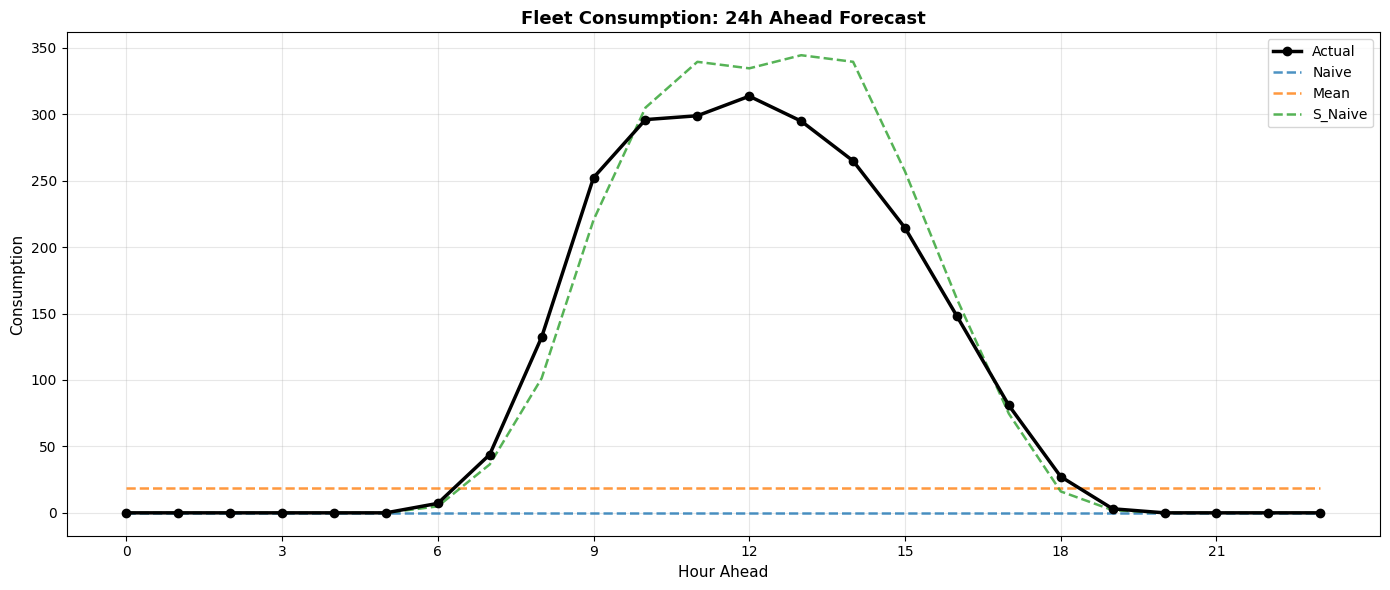

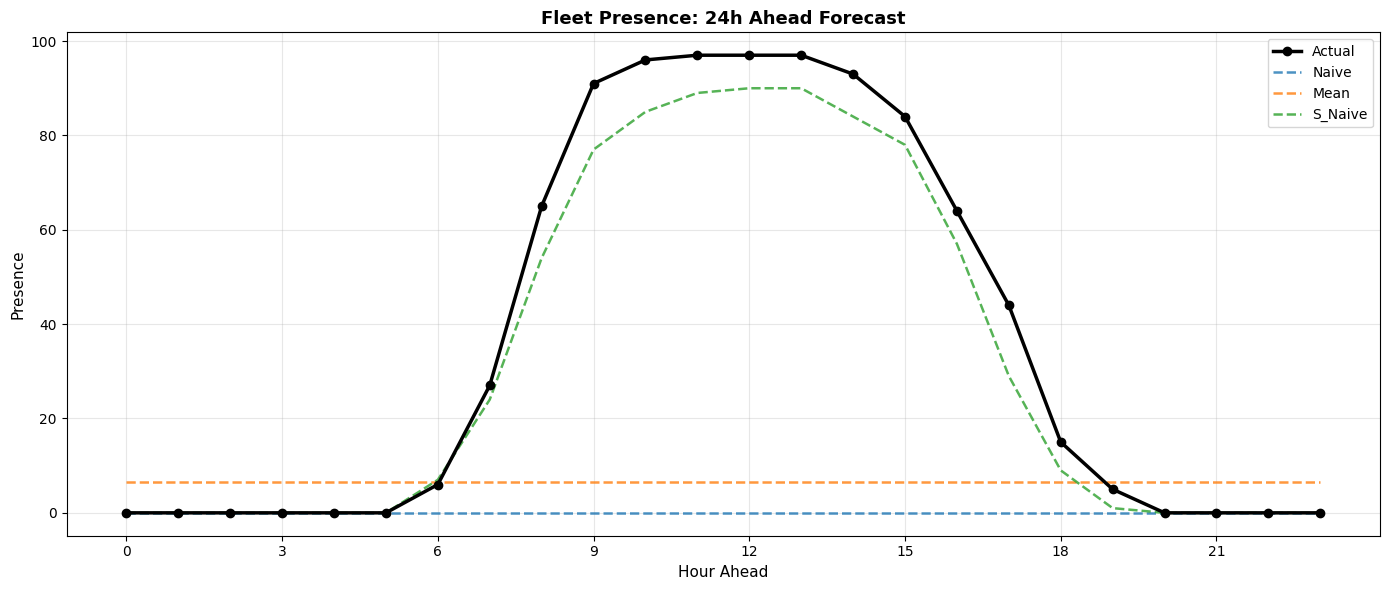

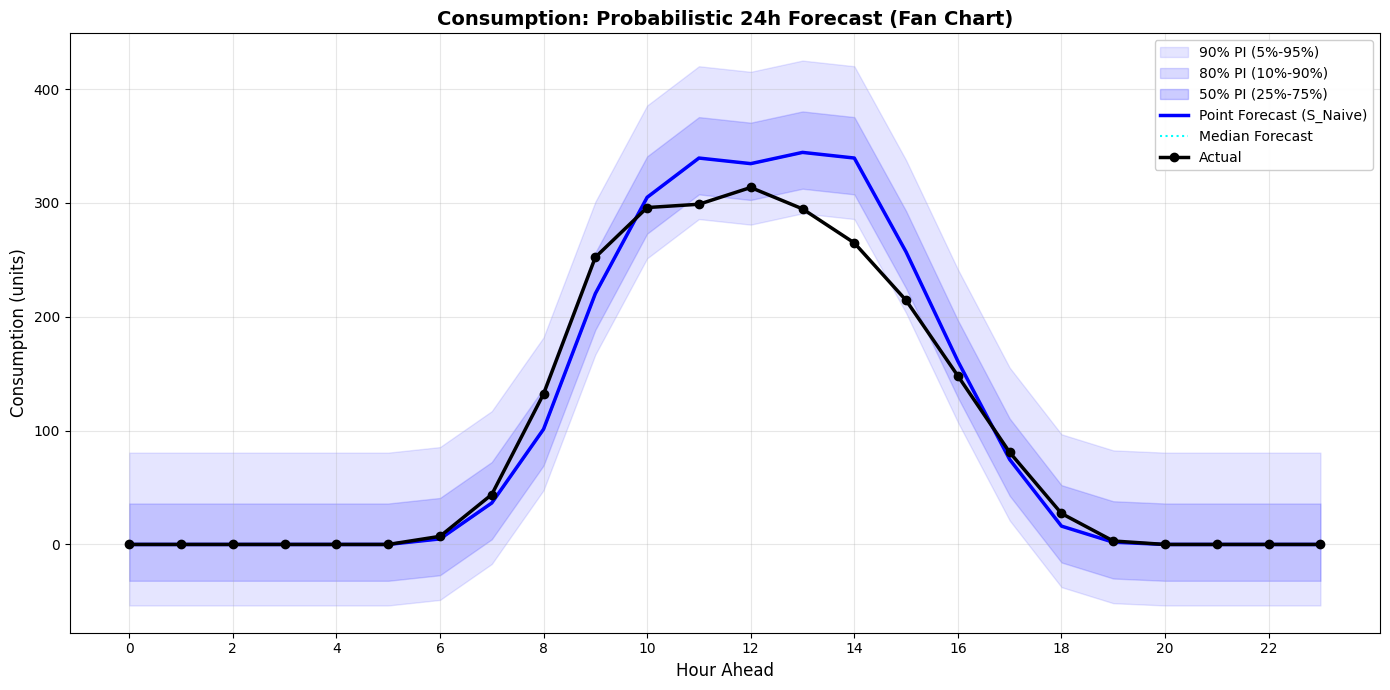

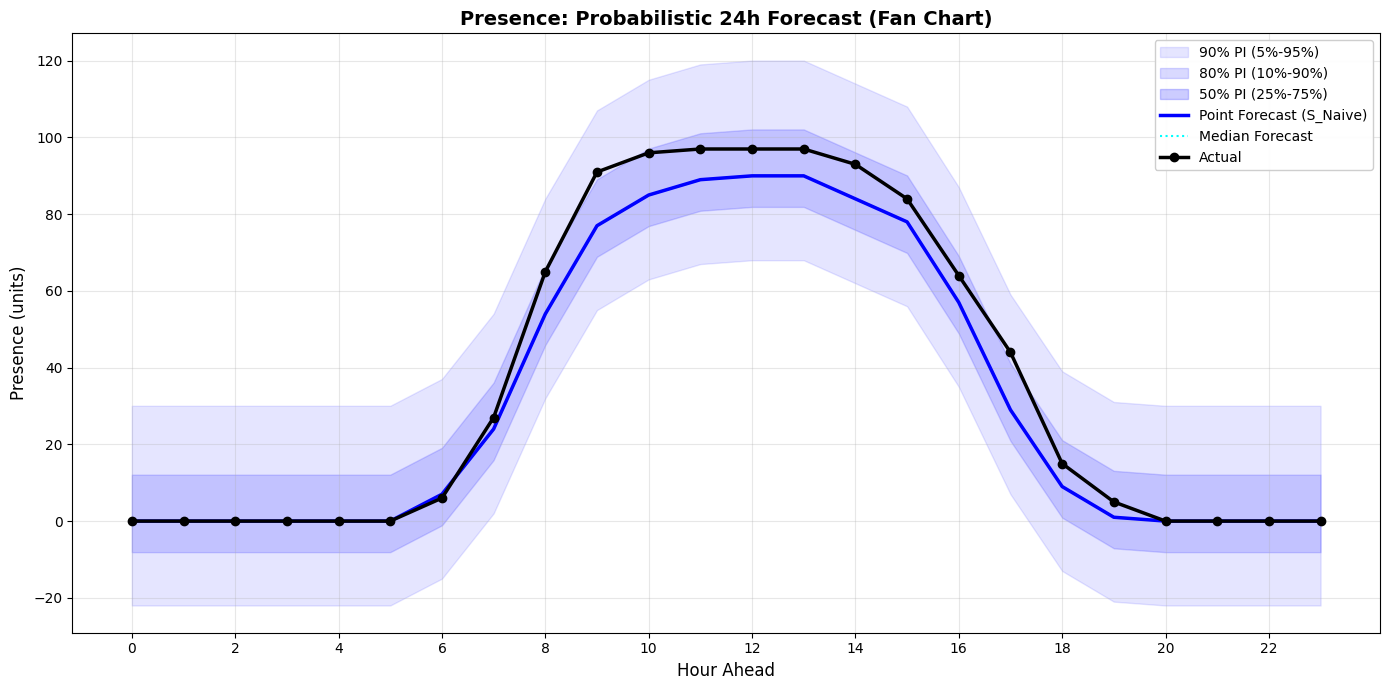

In [34]:
# 1. Benchmark rail
bench_c = benchmark_per_rail(rail_ts['consumption'], 'consumption')
bench_p = benchmark_per_rail(rail_ts['presence'], 'presence')

# 2. Benchmark fleet
benchmark_fleet(fleet_ts['consumption'], 'consumption')
benchmark_fleet(fleet_ts['presence'], 'presence')

# 3. Plot
fig1 = plot_fleet_forecast(fleet_ts['consumption'], target_name='Consumption')
fig2 = plot_fleet_forecast(fleet_ts['presence'], target_name='Presence')

# 4. Probabilistic forecasts
fig_prob_c, fc_c = plot_probabilistic_forecast(fleet_ts['consumption'], target_name='Consumption')
print_probabilistic_summary(fc_c)

fig_prob_p, fc_p = plot_probabilistic_forecast(fleet_ts['presence'], target_name='Presence')
print_probabilistic_summary(fc_p)

plt.show()

# SARIMA

FATTO TUTTO CON AI -> DA RIFARE

# LGBM MODEL